In [1]:
import os
import sys
import io
import h5py
import math
import attr
import time
import matplotlib.pyplot as plt
import glob
import datetime
import sqlite3
import numpy as np
import hdf5getters as GETTERS
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.mllib.stat import Statistics

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.35:7077") \
        .appName("strong_scaling")\
        .config("spark.executor.cores",2)\
        .config("spark.dynamicAllocation.enabled", False) \
        .config("spark.shuffle.service.enabled", False) \
        .getOrCreate()
        
sc = spark_session.sparkContext

In [2]:
def get_year(h5):   
    return int(h5["musicbrainz"]["songs"][0][1])

def get_artist_hotness(h5):
    x = float(h5["metadata"]["songs"][0][3])
    if math.isnan(x):
        return 0.0
    else:
        return x
def get_song_hotness(h5):
    x =  float(h5["metadata"]["songs"][0][16])
    if math.isnan(x):
        return 0.0
    else:
        return x
def get_loudness(h5):
    x = float(h5["analysis"]["songs"][0][23])
    if math.isnan(x):
        return 0.0
    else:
        return x
def get_tempo(h5):
    x = float(h5["analysis"]["songs"][0][27])
    if math.isnan(x):
        return 0.0
    else:
        return x

def f(tup):
    _path, data = tup
    with io.BytesIO(data) as b, h5py.File(b, "r") as f:
        return get_year(f), get_song_hotness(f), get_artist_hotness(f), get_loudness(f), get_tempo(f)

In [7]:
start_time = time.time()

A_list = ["A"]
B_list = ["A", "B"]
C_list = ["A", "B","C","D","E","F","G","H","I","J","K","L","M","N","O", "P","Q", "R","S", "T","U","V","W","X","Y","Z"]

all_paths = ""
i = 0
for letter in A_list:
    path1 = "hdfs://192.168.2.35:9000/A/" + letter + "/"
    for letter in B_list:
        path2 = path1 + letter + "/"
        for letter in C_list:
            path3 = path2 + letter + "/*"
            if i == 0:
                all_paths = path3
                i += 1
                path3 = ""
            else:
                all_paths = all_paths + "," + path3
                path3 = ""
files = sc.binaryFiles(all_paths)

In [8]:
rdd2 = files.map(lambda x: f(x))       

rdd3 = rdd2.filter(lambda x: len(x) == 5)\
    .filter(lambda x: x[0] >= 1980)\
    .filter(lambda x: type(x[0]) == int and type(x[1])== float and type(x[2])== float and \
            type(x[3])== float and type(x[4])== float)

In [9]:
rdd_song_hotness = rdd3.map(lambda x: x[1])
rdd_artist_hotness = rdd3.map(lambda x: x[2])
rdd_loudness = rdd3.map(lambda x: x[3])
rdd_tempo = rdd3.map(lambda x: x[4])

corr_artist = Statistics.corr(rdd_song_hotness, rdd_artist_hotness, method="pearson")
corr_loudness = Statistics.corr(rdd_song_hotness, rdd_loudness, method="pearson")
corr_tempo = Statistics.corr(rdd_song_hotness, rdd_tempo, method="pearson")

print("Correlation song hotness and artist hotness: ", corr_artist,
"\nCorrelation song hotness and loudness: ", corr_loudness,
"\nCorrelation song hotness and tempo: ", corr_tempo)

Correlation song hotness and artist hotness:  0.25210969290623153 
Correlation song hotness and loudness:  0.12226923674273363 
Correlation song hotness and tempo:  0.04604195104205415


In [10]:
end_time = time.time()
execution_time2 = end_time - start_time
print(execution_time2)

222.20344829559326


In [12]:
#------------ Strong scaling test ------------
# The strong scaling was done on a fixed dataset. The fixed dataset was the folders of files /A/A/A/A-Y and /A/A/B/A-Y
# The execution time was first run with both slaves which gave the execution time "time_6_cores" and then with
# one slave which gave the time "time_4_cores. Then another slave was added which gave the "time_8_cores"
time_4_cores = 323.2746410369873
time_6_cores = 270.50176787376404
time_8_cores = 224.67982172966003

In [13]:
# More data
time_4_cores = 323.2746410369873
time_6_cores = 270.50176787376404
time_8_cores = 224.67982172966003

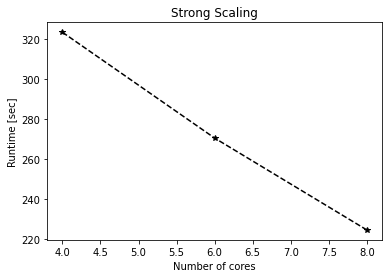

In [16]:
time = [time_4_cores, time_6_cores, time_8_cores]
cores = [4, 6, 8]
plt.plot(cores, time, 'k*--')
plt.title('Strong Scaling')
plt.xlabel('Number of cores')
plt.ylabel('Runtime [sec]')
plt.show()

In [2]:
sc.stop()